# Variational Classifier

A **variational quantum circuit** is a parametrized quantum algorithm $U(\vec{\theta})$, where $U(\vec{\theta})$ is a unitary operator and $\vec{\theta}$ is a vector of parameters. A **variational classifier** is a specific type of variational circuit where the parameters $\vec{\theta}$ are optimized to learn a classification function $f: D \to \{0, 1\}$, based on a train dataset (i.e., based on the behavior of $f$ on a subset of $D$). This function $f$ is used to label data from a given dataset $D$, and usually $D\subset \mathbb{R}^n$. 

The first step of a variational classifier is a **data encoding** which is a process to transform classical data into quantum states. Some examples of data encodings are the *basis encoding*, *amplitude encoding* and *angle encoding*. The second step is the application of $k$ consecutive *layers*. A *layer* is usually decomposed into two parametrized unitary operators $A(\alpha)$ and $B(\beta)$, where $A(\alpha)$ contains only single-qubit gates, and $B(\beta)$ is an entangler operator containing single-qubit and entangling gates. The most common layer is the *Strongly Entangling Layer*, which applies to each qubit an arbitrary rotation parametrized by 3 angles, and then applies CNOT gates as in Figure 1.

<figure style="text-align: center">
  <img src="images/strongly-entangling-layer.png" alt="Strongly Entangling Layer">
  <figcaption>Figure 1. A Strongly Entangling Layer in a 4-qubit circuit. Each 'Rot' gate is an arbitrary rotation parametrized by 3 angles.</figcaption>
</figure>

At the end of a variational circuit we obtain the expected value of an observable $\hat{M}$, obtaining a scalar 
$$g(\vec{\theta}) = \langle 0 | U(\vec{\theta})^\dag \hat{M} U(\vec{\theta}) | 0 \rangle.$$
Sometimes $g$ is minimized, but we could also make a post-processing to obtain another cost function that depends on $\vec{\theta}$ and on the training dataset. Later we will see which observable is suitable for a variational classifier. 

In this task, we show how to learn two classification functions with a quantum variational classifier:
1. The parity function $f: \{0, 1\}^n \to \{0,1\}$ given by $f(x)=1$ if $x$ has an uneven number of 1's, and $f(x)=0$ in another case;
2. The classification function of the well-known Iris dataset, considering only two classes of flowers.

First, we do the necessary imports.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt

Then, we create the quantum device where the quantum circuits will be executed. In our case, we use a simulator.

In [2]:
dev = qml.device("default.qubit") # Device where the quantum circuits will be executed

## Learning the parity function

In this section we explain how to learn the parity function with only a subset of all the domain $\{0, 1\}^n$. In the code, we use $n=4$.

We use the basis encoding that maps $x\in \{0, 1\}^n$ into $|x\rangle$, e.g., $(0, 1, 0, 1)\mapsto |0101\rangle$. Also we use the strongly entangling layer for the variational circuit.

In [3]:
def layer(layer_weights: np.tensor):
    """Strongly entangling layer with parameters given by the tensor layer_weights of size (n, 3), where n is the number of qubits.
    layer_weights[i] correspond to the 3 parameters for the arbitrary rotation applied to qubit i.

    :param layer_weights: Tensor of size (n, 3), where n is the number of qubits.
    :type layer_weights: np.tensor
    """
    n = layer_weights.shape[0]  # number of qubits

    # Apply an arbitrary single-qubit rotations to each qubit. Each rotation is parametrized by 3 angles
    for wire in range(n):
        qml.Rot(*layer_weights[wire], wires=wire)

    # entangling sublayer with CNOTs
    for wires in [[i, (i + 1) % n] for i in range(n)]:
        qml.CNOT(wires)


def state_preparation(x: np.tensor):
    """Prepare the basis state |x>, where x is a vector of 0's and 1's

    :param x: Tensor of size n (number of qubits) with 0's and 1's
    :type x: np.tensor
    """
    n = len(x)
    qml.BasisState(x, wires=range(n))

The variational quantum circuit consists of the state preparation process given by the chosen data encoding, followed by $k$ strongly entangling layers. Here we use $k=2$. At the end of the circuit, we obtain the expected value of a $Z$ measurement on the first qubit, add some *bias*, and finally take the sign of that sum to obtain a final classification (-1 or 1 instead of 0 or 1). 

In [4]:
# quantum node where the quantum function (circuit) will be executed in the given device
@qml.qnode(dev)
def circuit(weights: np.tensor, x: np.tensor) -> float:
    """Variational quantum circuit that receives the parameters ``weights`` of the circuit and the classical data in vector ``x``. It returns the expected value of the Z observable on the first qubit.

    :param weights: A tensor of size (k, n, 3), where k is the number of layers of the variational circuit and n is the number of qubits. weights[i][j] are the 3 parameters of the arbitrary rotation applied
    to qubit j in the i-th layer.
    :type weights: np.tensor
    :param x: 1D tensor of size n that represents the classical data.
    :type x: np.tensor
    :return: The expected value of the Z observable on the first qubit.
    :rtype: float
    """
    state_preparation(x)  # data encoding
    qml.Barrier(only_visual=True)

    for layer_weights in weights:
        layer(layer_weights)  # strongly entangling layer
        qml.Barrier(only_visual=True)

    return qml.expval(
        qml.PauliZ(0)
    )  # expected value of a Z measurement on the first qubit


def variational_classifier(weights: np.tensor, bias: np.tensor, x: np.tensor) -> float:
    """Variational classifier that runs the quantum circuit with the given parameters (tensor ``weights`` and bias) and classical data x, and then add some bias to the result.

    :param weights: A tensor of size (k, n, 3), where k is the number of layers of the variational circuit and n is the number of qubits. weights[i][j] are the 3 parameters of the arbitrary rotation applied
    to qubit j in the i-th layer.
    :type weights: np.tensor
    :param bias: A 0-dimensional tensor (scalar) for the bias.
    :type bias: np.tensor
    :param x: Vector of classical data
    :type x: np.tensor
    :return: Output of circuit plus bias
    :rtype: float
    """
    return circuit(weights, x) + bias


def predict(weights: np.tensor, bias: np.tensor, x: np.tensor) -> float:
    """Returns the predicted label (1 or -1) for the data vector x, depending on the sign of the variational classifier output.

    :param weights: A tensor of size (k, n, 3), where k is the number of layers of the variational circuit and n is the number of qubits. weights[i][j] are the 3 parameters of the arbitrary rotation applied
    to qubit j in the i-th layer.
    :type weights: np.tensor
    :param bias: A 0-dimensional tensor (scalar) for the bias.
    :type bias: np.tensor
    :param x: Vector of classical data
    :type x: np.tensor
    :return: Predicted label for vector x, 1 or -1.
    :rtype: float
    """
    return np.sign(variational_classifier(weights, bias, x))

Below is the diagram of the quantum circuit.

Initial parameters
Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]
Bias:  0.0

Quantum circuit diagram


Matplotlib is building the font cache; this may take a moment.


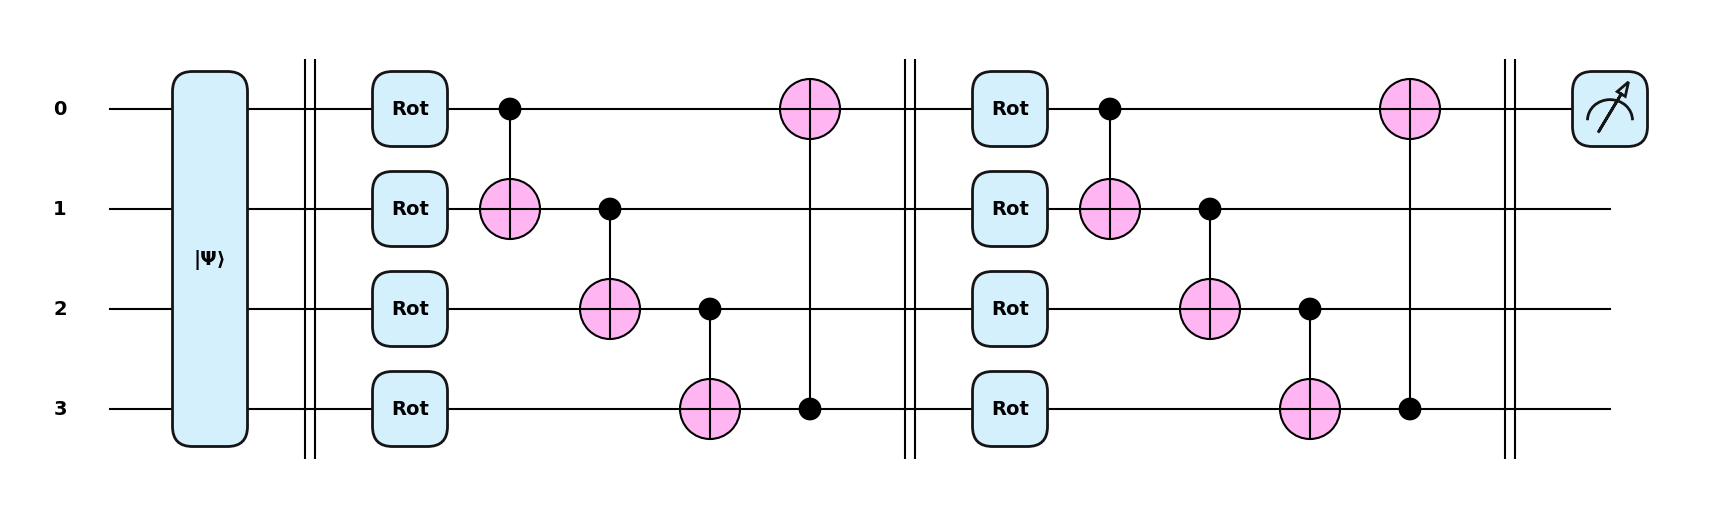

In [5]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True) # random initial parameters
bias_init = np.array(0.0, requires_grad=True)

print("Initial parameters")
print("Weights:", weights_init)
print("Bias: ", bias_init)

print("\nQuantum circuit diagram")
qml.draw_mpl(circuit, style="pennylane")(weights_init, [0,0,1,0])
plt.show()

To find the optimal parameters for the variational classifier that *learns* the parity function, we need to define an optimization problem. The cost function we use for this optimization problem is the squared loss, which is the sum of the squared differences between the variational classifier outputs and the real labels for the training dataset.

In [6]:
def square_loss(labels: np.tensor, predictions: np.tensor) -> float:
    """Squared loss: sum of the squared differences between the labels and the predictions

    :param labels: Real labels
    :type labels: np.tensor
    :param predictions: Predictions made by the variational classifier
    :type predictions: np.tensor
    :return: Squared loss
    :rtype: float
    """

    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)


def accuracy(labels: np.tensor, predictions: np.tensor) -> float:
    """Compute the accuracy of a model given its predictions and real labels.

    :param labels: Real labels
    :type labels: np.tensor
    :param predictions: Predictions made by the variational classifier
    :type predictions: np.tensor
    :return: Accuracy of the variational classifier given its predictions and real labels
    :rtype: float
    """

    acc = sum(
        abs(l - p) < 1e-5 for l, p in zip(labels, predictions)
    )  # if |l -p| < 1e-5, the prediction p for label l was successful
    acc = acc / len(labels)

    return acc


def cost(weights: np.tensor, bias: np.tensor, X: np.tensor, Y: np.tensor) -> float:
    """Cost function for the optimization problem

    :param weights: A tensor of size (k, n, 3), where k is the number of layers of the variational circuit and n is the number of qubits. weights[i][j] are the 3 parameters of the arbitrary rotation applied
    to qubit j in the i-th layer.
    :type weights: np.tensor
    :param bias: A 0-dimensional tensor (scalar) for the bias.
    :type bias: np.tensor
    :param X: Matrix with dataset to be evaluated
    :type X: np.tensor
    :param Y: Real labels of data in X
    :type Y: np.tensor
    :return: Squared loss
    :rtype: float
    """

    predictions = [
        variational_classifier(weights, bias, x) for x in X
    ]  # predictions without taking the sign function.

    return square_loss(Y, predictions)

The following code loads the training dataset for the parity function. Instead of labels 0 and 1, we work with -1 and 1.

In [7]:
data = np.loadtxt("data/parity_train.txt", dtype=int)
X = data[:, :-1] # binary vectors
Y = data[:, -1] # labels (0, 1)
Y = Y * 2 - 1  # shift labels from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


With the help of a gradient-based optimization method, such as the Nesterov-Momentum method, we can optimize the cost function to find the optimal parameters for the variational classifier. The following code finds the optimal parameters through 100 iterations of the optimization method.

In [8]:
opt = NesterovMomentumOptimizer(0.5) # stepsize of 0.5 for the optimizer method
batch_size = 5 # compute gradient of cost function working with only a batch of data of size 5

In [9]:
# initial parameters
weights = weights_init
bias = bias_init
np.random.seed(0)

# 100 epochs for the optimization method
for it in range(100):

    # Update the weights by one optimizer step, using only a limited-random batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    
    # gradicent descent
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [predict(weights, bias, x) for x in X] 

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    if (it+1) % 5 == 0:
        print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    5 | Cost: 1.1597277 | Accuracy: 0.2000000
Iter:   10 | Cost: 0.9581590 | Accuracy: 0.6000000
Iter:   15 | Cost: 1.1682412 | Accuracy: 0.4000000
Iter:   20 | Cost: 1.2909768 | Accuracy: 0.6000000
Iter:   25 | Cost: 0.9037157 | Accuracy: 0.6000000
Iter:   30 | Cost: 0.9616219 | Accuracy: 0.8000000
Iter:   35 | Cost: 0.0920592 | Accuracy: 1.0000000
Iter:   40 | Cost: 0.0331178 | Accuracy: 1.0000000
Iter:   45 | Cost: 0.0196392 | Accuracy: 1.0000000
Iter:   50 | Cost: 0.0110559 | Accuracy: 1.0000000
Iter:   55 | Cost: 0.0007800 | Accuracy: 1.0000000
Iter:   60 | Cost: 0.0029514 | Accuracy: 1.0000000
Iter:   65 | Cost: 0.0002610 | Accuracy: 1.0000000
Iter:   70 | Cost: 0.0000336 | Accuracy: 1.0000000
Iter:   75 | Cost: 0.0000248 | Accuracy: 1.0000000
Iter:   80 | Cost: 0.0000598 | Accuracy: 1.0000000
Iter:   85 | Cost: 0.0000245 | Accuracy: 1.0000000
Iter:   90 | Cost: 0.0000142 | Accuracy: 1.0000000
Iter:   95 | Cost: 0.0000100 | Accuracy: 1.0000000
Iter:  100 | Cost: 0.0000050 | 

After finding the optimal parameters, we load the test data and see the performance of the variational classifier on it.

In [10]:
data = np.loadtxt("data/parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [predict(weights, bias, x) for x in X_test] 

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)


x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0


We see that the variational classifier is able to learn the parity function, because it has an accuracy of 100% in all the data (16 binary vectors).

## Iris classification

In this section we explain how to train a variational classifier using the Iris dataset. First we load the dataset, and consider only the first two dimensions of the data vectors. Here we use amplitude encoding to map our data into a quantum state. Amplitude encoding maps a unit vector $x\in \mathbb{C}^{2^n}$, $||x|| = 1$, into the amplitudes of a quantum state, that is,
$$
x \mapsto \sum_{i=0}^{2^n - 1} x_i |i\rangle.
$$

Real world data vectors are not usually normalized, and we may lose information if we normalize them. So we add some extra (*latent*) dimensions to avoid information loss. In our example, we add two more dimensions with constant values to each data vector and then normalize them. After that, we will have 4-dimensional unit vectors that can be embedded into quantum states using 2 qubits.

In [11]:
data = np.loadtxt("data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]


According to [Schuld and Petruccione (2018)](https://link.springer.com/book/10.1007/978-3-319-96424-9), the circuit defined in the ``state_preparation`` function performs the amplitude encoding (the corresponding diagram is shown below). This state preparation applies five $RY$ rotation gates with suitable angles. Given a 4-dimensional unit vector $x$, we obtain 5 angles $\vec{a} = (a_1, \ldots, a_5)$ with the function ``get_angles``, and the ``state_preparation`` function uses those angles to perform the amplitude encoding of the vector $x$ into a quantum state of 2 qubits.

In [12]:
def get_angles(x: np.tensor) -> np.tensor:
    """Given a 4-dimensional unit vector x, obtain 5 angles that allow ``state_preparation`` to perform amplitude encoding of vector x

    :param x: 4-dimensional unit vector x
    :type x: np.tensor
    :return: 5-dimensional vector of the suitable angles for the amplitude encoding
    :rtype: np.tensor
    """

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def state_preparation(a: np.tensor):
    """Amplitude encoding of a 4-dimensional unit vector, using the corresponding angles given by the ``get_angles`` function.

    :param a: 5-dimensional vector of the suitable angles for the amplitude encoding
    :type a: np.tensor
    """

    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968+0.j  0.795036+0.j  0.278265+0.j -0.      +0.j]

State preparation diagram


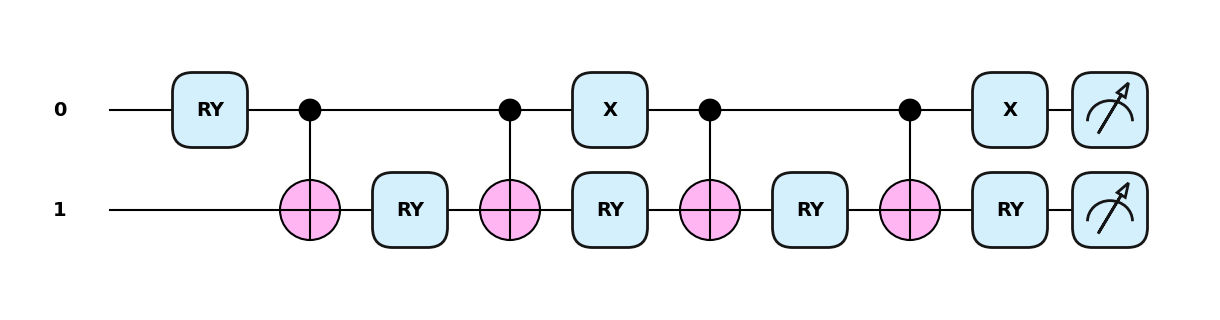

In [13]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False) # unit vector
ang = get_angles(x) 


@qml.qnode(dev)
def amplitude_encoding(angles: np.tensor):
    state_preparation(angles)

    return qml.state()


state = amplitude_encoding(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(state, 6))
print("\nState preparation diagram")
qml.draw_mpl(amplitude_encoding, style="pennylane")(ang)
plt.show()

For training purposes, we work only with the angle vectors associated to each data vector, given by the ``get_angles`` function. Those angle vectors are the feature vectors of our ML problem.

In [14]:
# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


Below is a figure showing different 2D visualizations of the data: the original data, the padded and normalized data, and the feature vectors.

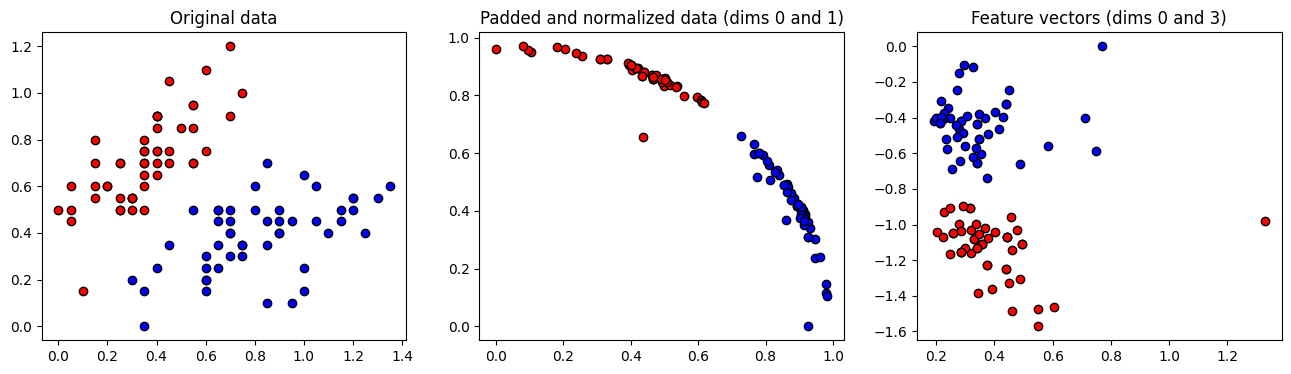

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
ax[0].scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
ax[0].set_title("Original data")

dim1, dim2 = 0, 1
ax[1].scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
ax[1].scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
ax[1].set_title(f"Padded and normalized data (dims {dim1} and {dim2})")

dim1, dim2 = 0, 3
ax[2].scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
ax[2].scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
ax[2].set_title(f"Feature vectors (dims {dim1} and {dim2})")

plt.show()

To define the variational classifier we need to consider the structure of each layer. For this example, we consider a layer that consists of an arbitrary rotation applied to each qubit and then one CNOT gate. We repeat this layer 6 times. Below is a diagram of the complete quantum circuit for the variational classifier. In the code, we reuse the ``circuit`` and the ``variational_classifier`` functions from the previous example and only need to define the ``layer`` and ``state_preparation`` functions. 

In [16]:
def layer(layer_weights: np.tensor):
    """Two-qubit layer with parameters given by the tensor layer_weights of size (2, 3).
    layer_weights[i] correspond to the 3 parameters for the arbitrary rotation applied to qubit i.

    :param layer_weights: Tensor of size (2, 3).
    :type layer_weights: np.tensor
    """
    
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
        
    qml.CNOT(wires=[0, 1])


def cost(weights: np.tensor, bias: np.tensor, X: np.tensor, Y: np.tensor) -> float:
    """Cost function for the optimization problem

    :param weights: A tensor of size (k, n, 3), where k is the number of layers of the variational circuit and n is the number of qubits. 
    weights[i][j] are the 3 parameters of the arbitrary rotation applied to qubit j in the i-th layer.
    :type weights: np.tensor
    :param bias: A 0-dimensional tensor (scalar) for the bias.
    :type bias: np.tensor
    :param X: Matrix with dataset to be evaluated
    :type X: np.tensor
    :param Y: Real labels of data in X
    :type Y: np.tensor
    :return: Squared loss
    :rtype: float
    """
    
    # Transpose the batch of input data in order to make the indexing in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)


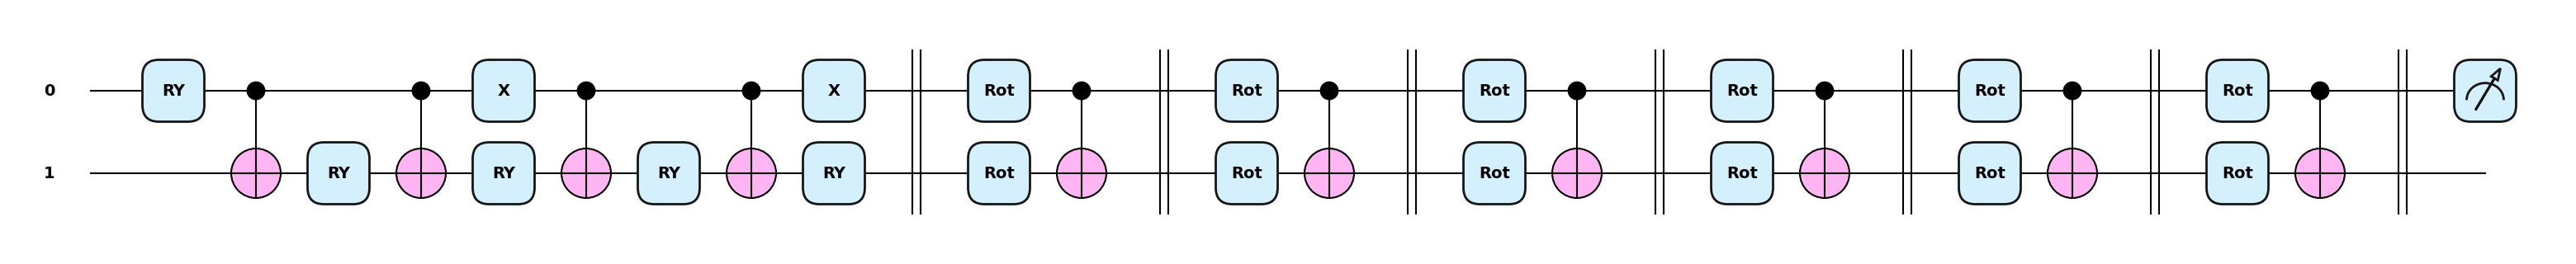

In [17]:
np.random.seed(0)

num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

qml.draw_mpl(circuit, style="pennylane")(weights_init, features[0])
plt.show()

Next, we split our data into a training and validation datasets. Using the Nesterov-Momentum optimization method, we find the optimal parameters for the variational classifier based on the defined cost function (the squared loss). We perform 60 iterations of the optimization method.

In [18]:
num_data = len(Y)
num_train = int(0.75 * num_data) # 75% of the data is for training
index = np.random.permutation(range(num_data)) # random permutation of indices

# training dataset
feats_train = features[index[:num_train]] 
Y_train = Y[index[:num_train]]

# validation dataset
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

In [19]:
opt = NesterovMomentumOptimizer(0.01) # 0.01 of step size
batch_size = 5

# initial parameters
weights = weights_init
bias = bias_init

# train the variational classifier
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = predict(weights, bias, feats_train.T)
    predictions_val = predict(weights, bias, feats_val.T)

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )


Iter:     2 | Cost: 1.6102929 | Acc train: 0.5200000 | Acc validation: 0.4400000
Iter:     4 | Cost: 1.2871144 | Acc train: 0.5333333 | Acc validation: 0.4400000
Iter:     6 | Cost: 0.9879918 | Acc train: 0.5600000 | Acc validation: 0.4800000
Iter:     8 | Cost: 1.0913482 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    10 | Cost: 1.3461149 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    12 | Cost: 1.3902814 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    14 | Cost: 1.0349249 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    16 | Cost: 0.8530664 | Acc train: 0.6933333 | Acc validation: 0.8800000
Iter:    18 | Cost: 0.8772262 | Acc train: 0.6400000 | Acc validation: 0.6000000
Iter:    20 | Cost: 0.9263095 | Acc train: 0.5333333 | Acc validation: 0.4400000
Iter:    22 | Cost: 0.9517859 | Acc train: 0.5333333 | Acc validation: 0.4400000
Iter:    24 | Cost: 0.7956183 | Acc train: 0.6800000 | Acc validation: 0.7200000
Iter:    26 | Cost: 0.644719

We observe that the variational classifier is able to predict the correct labels even for unseen data. Below is a figure showing the first two dimensions of the Iris dataset, along with a heatmap of the continuous output of the variational classifier. The region of data vectors labeled with -1 is shown in red, while the region of the data vectors labeled with 1 is shown in blue. The black-dotted line represents the output 0 of the variational classifier, and it separates the two classes.

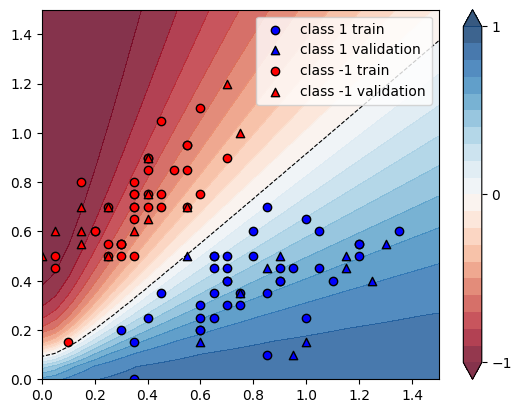

In [20]:
plt.figure()
cm = plt.cm.RdBu

X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()
